In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import gseapy as gp
import statsmodels.api as sm
from adjustText import adjust_text

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# scDRS tools
import scdrs.util as util
import scdrs.data_loader as dl
import scdrs.method as md

# autoreload
%load_ext autoreload
%autoreload 2

- Set `DATA_PATH` to your local `scDRS_data_release_092121` folder
- Set `SCORE_FILE_PATH` to your local `scDRS_data_release_092121.score_file_tmsfacs` folder

In [2]:
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data_release_092121'
SCORE_FILE_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data_release_092121.score_file_tmsfacs'

## Code to reproduce main results of the paper

In [3]:
# Set file paths
DF_HOM = pd.read_csv(DATA_PATH+'/gene_annotation/mouse_human_homologs.txt', sep='\t')
DIC_MAP_H2M = {x:y for x,y in zip(DF_HOM['HUMAN_GENE_SYM'], DF_HOM['MOUSE_GENE_SYM'])}
DIC_MAP_M2H = {x:y for x,y in zip(DF_HOM['MOUSE_GENE_SYM'], DF_HOM['HUMAN_GENE_SYM'])}
DF_GS = pd.read_csv(DATA_PATH+'/gs_file/magma_10kb_1000.74_traits.gs', sep='\t', index_col=0)
DF_TRAIT_INFO = pd.read_csv(DATA_PATH+'/supp_table/trait_info.tsv', sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
# FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_tcell'

# Set data info
DS_LIST = ['tms_facs']
DIC_INFO = {}
DIC_INFO['tms_facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}

# Set score file
DIC_SCORE_PATH = {'tms_facs': SCORE_FILE_PATH,
                 }

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['tms_facs'] = ['PASS_IBD_deLange2017', 'PASS_CD_deLange2017','PASS_UC_deLange2017',
                              'PASS_Rheumatoid_Arthritis', 'PASS_Multiple_sclerosis', 'UKB_460K.disease_AID_ALL', 
                              'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',
                              'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED',
                              'UKB_460K.disease_ASTHMA_DIAGNOSED', 
                              'UKB_460K.disease_RESPIRATORY_ENT',
                              'UKB_460K.body_HEIGHTz']

### Load data 

In [4]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['tms_facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')

dic_data_proc = {}
dic_data_proc['tms_facs'] = read_h5ad(DATA_PATH+'/single_cell_data/tms_proc/tcell.facs.annot.h5ad')

Trying to set attribute `.obs` of view, copying.


In [5]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = DIC_SCORE_PATH[score]+'/%s.score.gz'%trait
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

# Cell list to analyze
dic_cell_list = {}
for ds in DS_LIST:
    dic_cell_list[ds] = sorted(set(dic_data_proc[ds].obs_names) & set(dic_score[ds].index))

In [6]:
# Load control score 
dic_ctrl_score = {}
for score in DIC_SCORE_PATH:
    ds = score.split('.')[0]
    dic_ctrl_score[score] = {}
    for trait in DIC_TRAIT_LIST[score]:
        file_path = DIC_SCORE_PATH[score]+'/%s.full_score.gz'%trait
        if os.path.exists(file_path):
            print('# Loading %s %s'%(score, trait))
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            dic_ctrl_score[score][trait] = temp_df.loc[dic_cell_list[ds]].copy()
        else:
            print('# missing: %s'%file_path)

# Loading tms_facs PASS_IBD_deLange2017
# Loading tms_facs PASS_CD_deLange2017
# Loading tms_facs PASS_UC_deLange2017
# Loading tms_facs PASS_Rheumatoid_Arthritis
# Loading tms_facs PASS_Multiple_sclerosis
# Loading tms_facs UKB_460K.disease_AID_ALL
# Loading tms_facs UKB_460K.disease_HYPOTHYROIDISM_SELF_REP
# Loading tms_facs UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED
# Loading tms_facs UKB_460K.disease_ASTHMA_DIAGNOSED
# Loading tms_facs UKB_460K.disease_RESPIRATORY_ENT
# Loading tms_facs UKB_460K.body_HEIGHTz


### UMAP for all T cells 

n_tissue=15, BAT,Brain_Non-Myeloid,Diaphragm,GAT,Heart,Kidney,Limb_Muscle,Liver,Lung,MAT,Marrow,SCAT,Skin,Spleen,Trachea


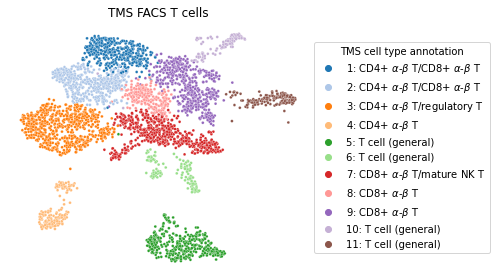

In [7]:
adata = dic_data_proc['tms_facs'].copy()
tissue_list = sorted(adata.obs['tissue'].unique())
print('n_tissue=%d, %s'%(len(tissue_list), ','.join(tissue_list)))
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]}, dtype=float)
df_plot = df_plot.join(adata.obs[['leiden_reorder', 'leiden_anno']])
df_plot['label'] = ['%s: %s'%(x,y) for x,y in zip(df_plot['leiden_reorder'], df_plot['leiden_anno'])]
df_plot['label'] = df_plot['label'].astype('category')

hue_list = []
for x in df_plot['leiden_reorder'].cat.categories:
    for y in set(df_plot['label']):
        if y.startswith('%s: '%x):
            hue_list.append(y)

plt.figure(figsize=[7,4])
ax = plt.subplot(1,1,1)
ax.axis('off')
g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='label', s=8, palette='tab20', hue_order=hue_list)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, title="TMS cell type annotation")
plt.title('TMS FACS T cells')
plt.tight_layout()
# plt.savefig(FIG_PATH+'/tcell_tms_annot_umap.svg')
plt.show()

### Annotation for PASS_IBD_deLange2017 associated cells 

# cluster 3: 120/629 significant (509 nonsig)


,cell
cell_ontology_class,
"CD4-positive, alpha-beta T cell",80.0
"CD8-positive, alpha-beta T cell",4.0
T cell,23.0
regulatory T cell,13.0


# cluster 4: 75/165 significant (90 nonsig)


,cell
cell_ontology_class,
"CD4-positive, alpha-beta T cell",27.0
"CD8-positive, alpha-beta T cell",1.0
T cell,47.0


# cluster 5: 61/370 significant (309 nonsig)


,cell
cell_ontology_class,
"CD4-positive, alpha-beta T cell",1.0
"CD8-positive, alpha-beta T cell",1.0
T cell,58.0
mature NK T cell,1.0


# cluster 9: 38/499 significant (461 nonsig)


,cell
cell_ontology_class,
"CD4-positive, alpha-beta T cell",3.0
"CD8-positive, alpha-beta T cell",22.0
T cell,13.0


... storing 'tissue_celltype' as categorical
... storing 'leiden_reorder' as categorical
... storing 'leiden_sig' as categorical
... storing 'leiden_sig_full' as categorical


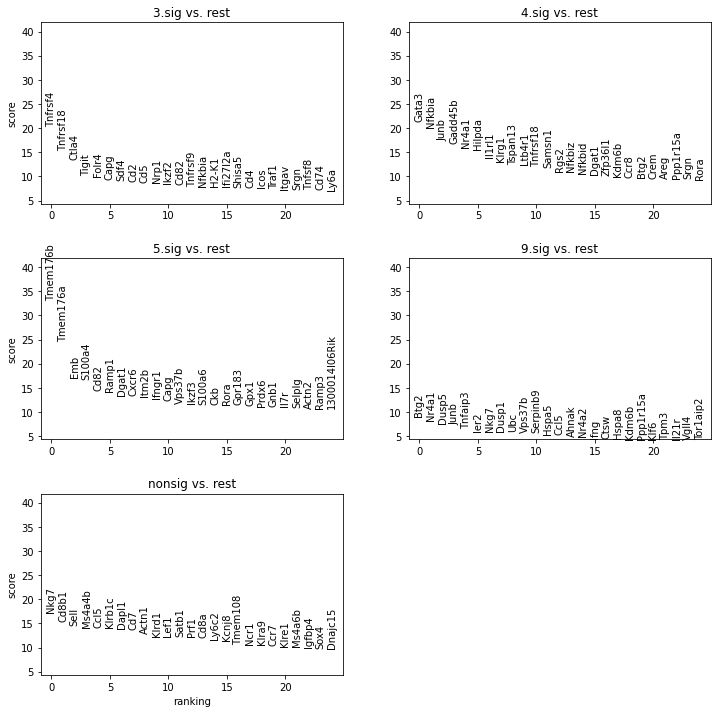

In [8]:
trait = 'PASS_IBD_deLange2017'
ds = 'tms_facs'

# Get adata 
adata = dic_data_raw[ds][dic_cell_list[ds], :].copy()
temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obs = adata.obs.join(temp_adata.obs[[x for x in temp_adata.obs.columns if x not in adata.obs.columns]])
adata.obsm = temp_adata.obsm.copy()
adata.obs['leiden_reorder'] = [str(x) for x in adata.obs['leiden_reorder']]

# Get leiden_sig (remove sig cells in small clusters)
adata.obs = adata.obs.join(dic_score[ds]['%s.fdr'%trait])
adata.obs['leiden_sig'] = ['%s.sig'%x if y<0.1 else 'nonsig'
                           for x,y in zip(adata.obs['leiden_reorder'], adata.obs['%s.fdr'%trait])]
temp_df = adata.obs.groupby(['leiden_sig']).agg({'cell':len})
cluster_remove_list = list(temp_df.index[temp_df['cell']<25])
adata.obs['leiden_sig_full'] = adata.obs['leiden_sig'].copy()
adata.obs.loc[adata.obs['leiden_sig'].isin(cluster_remove_list), 'leiden_sig'] = 'nonsig' 

# Summarize significant cells in each cluster
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
for group in group_list:
    print('# cluster %s: %d/%d significant (%d nonsig)'
          %(group.split('.')[0], (adata.obs['leiden_sig']==group).sum(), 
            (adata.obs['leiden_reorder']==group.split('.')[0]).sum(), 
            (adata.obs['leiden_reorder']==group.split('.')[0]).sum() - (adata.obs['leiden_sig']==group).sum()))
    temp_df = adata.obs.loc[adata.obs['leiden_sig']==group].copy()
    temp_df = temp_df.groupby('cell_ontology_class').agg({'cell':len})
    temp_df = temp_df.loc[temp_df['cell']>0]
    display(temp_df)

# Specifically expressed genes 
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
sc.tl.rank_genes_groups(adata, groupby='leiden_sig')
sc.pl.rank_genes_groups(adata, fontsize=10, ncols=2, n_genes=25)

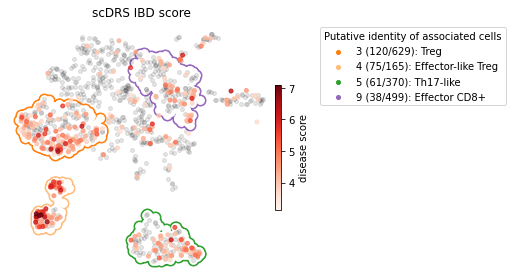

In [9]:
# UMAP plot with annotations 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
dic_config = {'3.sig': ['3 @a: Treg'], 
              # Ctla4 (Treg), Nrp1 (Treg), Tnfrsf18 (Treg), Ikzf2 (helios, Treg), Tnfrsf4 (OX40, effector)
              '4.sig': ['4 @a: Effector-like Treg'],
              # Li_CR_2019, effector Treg-like
              '5.sig': ['5 @a: Th17-like'], 
              # Cd4- Cd8-, may not be typical T cells
              '9.sig': ['9 @a: Effector CD8+']
              # Fasl (CD8+ cytotoxic T), Ifng (CD8+ cytotoxic T), Ccl5 (HIV-suppressive factor)
             }
cmap = matplotlib.cm.get_cmap('tab20')

# Get df_plot 
df_plot = pd.DataFrame(index=adata.obs_names, data={'UMAP1':adata.obsm['X_umap'][:,0],
                                                    'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['leiden_reorder', 'leiden_sig', 'leiden_sig_full']])
df_plot = df_plot.loc[dic_cell_list[ds]].copy()
df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.norm_score'%trait]])
df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

# Figure 
plt.figure(figsize=[7.2,4])
ax = plt.subplot(1,1,1)
ax.axis('off')

# Cluster boundry 
x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
for cluster in group_list:
    ind_select = df_plot['leiden_reorder']==cluster.split('.')[0]
    assoc_str = '(%d/%d)'%((ind_select&(df_plot['leiden_sig']!='nonsig')).sum(), ind_select.sum())
    temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
    xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
    xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
    ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
    ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
    ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
                    (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
                s=16, color=cmap(int(cluster.split('.')[0])-1),
                label=dic_config[cluster][0].replace('@a',assoc_str), zorder=0)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=120, color=cmap(int(cluster.split('.')[0])-1), zorder=1)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=60, color='w', zorder=2)

ind_select_sig = (df_plot['leiden_sig_full']!='nonsig')
np.random.seed(0)
cell_list_nonsig = np.random.choice(df_plot.index[~ind_select_sig], 
                                    size=int((~ind_select_sig).sum()*0.2), replace=False)
plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
                c='k', s=16, alpha=0.1, zorder=5)

vmax = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.99) + 0.5
vmin = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.01) - 0.5
plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
            c=df_plot.loc[ind_select_sig, '%s.norm_score'%trait],
            cmap='Reds', s=16, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
plt.colorbar(shrink=0.5, pad=0, label='disease score')
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', title='Putative identity of associated cells')
plt.title('scDRS %s score'%DF_TRAIT_INFO.loc[trait, 'Code'])
plt.tight_layout()
# plt.savefig(FIG_PATH+'/sctrs_assoc.annot_IBD_umap.svg')
plt.show()

### CD4/CD8 effector gradients

dpt_cd4_qn n_cell=1686, clusters=1,2,3,4


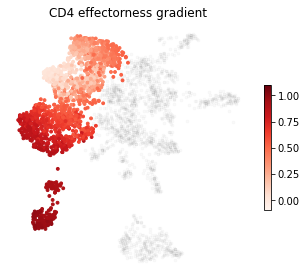

dpt_cd8_qn n_cell=2197, clusters=1,2,7,8,9


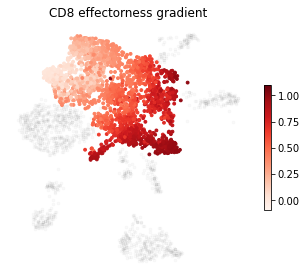

In [10]:
# Pseudotime: make it nicer later 
ds='tms_facs'
adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
dic_title = {'dpt_cd4_qn': 'CD4 effectorness gradient', 'facs_cd4': 'CD4 effectorness gradient',
             'dpt_cd8_qn': 'CD8 effectorness gradient', 'facs_cd8': 'CD8 effectorness gradient'}
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['dpt_cd4_qn', 'dpt_cd8_qn', 'leiden_reorder']])

for term in ['dpt_cd4_qn', 'dpt_cd8_qn']:    
    plt.figure(figsize=[4.5,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    ind_select = df_plot[term]>=0
    print('%s n_cell=%d, clusters=%s'%(term, ind_select.sum(), 
                                       ','.join([str(x) for x in sorted(set(df_plot.loc[ind_select,
                                                                                        'leiden_reorder']))])))
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', alpha=0.025, s=8)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=df_plot.loc[ind_select, term], cmap='Reds', vmax=1.1, vmin=-0.1, s=8)
    plt.colorbar(shrink=0.5)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title(dic_title[term])
    plt.tight_layout()
#     plt.savefig(FIG_PATH+'/%s.svg'%term)
    plt.show()

In [11]:
# Prepare regression datasets 
n_ctrl = 1000 
dic_cov = {}

# FACS CD4 
dic_cov['facs_cd4'] = dic_data_proc['tms_facs'].obs.copy()
dic_cov['facs_cd4']['effectorness'] = dic_cov['facs_cd4']['dpt_cd4_qn']
dic_cov['facs_cd4'] = dic_cov['facs_cd4'].loc[dic_cov['facs_cd4']['effectorness']>0].copy()

# FACS CD8 
dic_cov['facs_cd8'] = dic_data_proc['tms_facs'].obs.copy()
dic_cov['facs_cd8']['effectorness'] = dic_cov['facs_cd8']['dpt_cd8_qn']
dic_cov['facs_cd8'] = dic_cov['facs_cd8'].loc[dic_cov['facs_cd8']['effectorness']>0].copy()

# Add const and leiden
for cov_name in dic_cov:
    dic_cov[cov_name]['const'] = 1
    for cluster in set(dic_cov[cov_name]['leiden_reorder']):
        if (dic_cov[cov_name]['leiden_reorder']==cluster).sum()>0:
            dic_cov[cov_name]['leidenreg_%d'%cluster] = (dic_cov[cov_name]['leiden_reorder']==cluster)*1

In [12]:
# Regression analysis
dic_reg = {'reg_marginal': ['effectorness'],
           'reg_joint': ['effectorness', 'leidenreg']
          }

dic_stats = {}
for cov_name in dic_cov:
    for reg_name in dic_reg:
        print(cov_name, reg_name)
        reg_list = dic_reg[reg_name].copy()
        if 'leidenreg' in reg_list:
            reg_list.remove('leidenreg')
            ctrl_list = ['const'] + [x for x in dic_cov[cov_name].columns if 'leidenreg' in x]
        else:
            ctrl_list = ['const']
        df_stats = pd.DataFrame(columns=['var_ctrl','var']+['%s.%s'%(y,x) for x in reg_list for y in ['T', 'P']])
        ds = cov_name.split('_' )[0]
        
        for score in ['tms_facs']:
            for trait in DIC_TRAIT_LIST[score]:
                if '%s.norm_score'%trait not in dic_score[score]:
                    print('Missing', score, '%s.norm_score'%trait)
                    continue              

                df_reg = dic_cov[cov_name][reg_list+ctrl_list].copy()
                df_reg = df_reg.join(dic_score[score][['%s.norm_score'%trait]])
                df_reg = df_reg.join(dic_ctrl_score[score][trait])
                
                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[ctrl_list]).fit()
                var_explain_ctrl_ = 1 - res.mse_resid/res.mse_total

                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[ctrl_list+reg_list]).fit()
                var_explain_ = 1 - res.mse_resid/res.mse_total
                dic_t = {x:res.tvalues[x] for x in reg_list}
                dic_t_ctrl = {x:np.zeros(n_ctrl) for x in reg_list}

                for i in range(n_ctrl):
                    res = sm.OLS(df_reg['ctrl_norm_score_%d'%i], df_reg[ctrl_list+reg_list]).fit()
                    for reg in reg_list:
                        dic_t_ctrl[reg][i] = res.tvalues[reg]
                if trait in ['naive_cd4', 'naive_cd8']:
                    dic_p = {x:((dic_t[x] >= dic_t_ctrl[x]).sum()+1) / (n_ctrl+1) for x in reg_list} 
                else:
                    dic_p = {x:((dic_t[x] <= dic_t_ctrl[x]).sum()+1) / (n_ctrl+1) for x in reg_list} 
                df_stats.loc[trait] = [var_explain_ctrl_, var_explain_] + \
                    [y[x] for x in reg_list for y in [dic_t, dic_p]]

        for reg_term in reg_list:
            df_stats['P_STR.%s'%reg_term] = [util.p_2_str(x) for x in df_stats['P.%s'%reg_term]]
            df_stats['P_STR_NUM.%s'%reg_term] = [util.p_2_str_num(x,n_ctrl) for x in df_stats['P.%s'%reg_term]]
        dic_stats['%s.%s'%(cov_name, reg_name)] = df_stats

facs_cd4 reg_marginal
facs_cd4 reg_joint
facs_cd8 reg_marginal
facs_cd8 reg_joint


In [13]:
# Output table: Association p-values
trait_list = DIC_TRAIT_LIST['tms_facs'].copy()
df_res = pd.DataFrame(index=trait_list)
df_res['Trait'] = [DF_TRAIT_INFO.loc[x, 'Code'] for x in df_res.index]

for cov_name in dic_cov:
    term = 'CD4' if cov_name=='facs_cd4' else 'CD8'
    # Marginal regression
    temp_df = dic_stats['%s.reg_marginal'%(cov_name)][['P.effectorness', 'var']].copy()
    temp_df.columns = ['%s.P'%term, '%s.Var'%term]
    df_res = df_res.join(temp_df)
    
    # Joint regression 
    temp_df = dic_stats['%s.reg_joint'%(cov_name)][['var_ctrl', 'var', 'P.effectorness']]
    temp_df.columns = ['%s.Var.cluster'%term, '%s.Var.joint'%term, '%s.P.joint'%term]
    df_res = df_res.join(temp_df)
    
df_res = df_res[['Trait', 'CD4.P', 'CD4.Var', 'CD4.P.joint', 'CD8.P', 'CD8.Var', 'CD8.P.joint', ]]
for col in ['CD4.P', 'CD4.P.joint', 'CD8.P', 'CD8.P.joint']:
    df_res[col] = ['$\textbf{%0.3f}$'%x if x<0.005 else '$%0.3f$'%x for x in df_res[col]]
for col in ['CD4.Var', 'CD8.Var']:
    df_res[col] = ['%0.3f'%x for x in df_res[col]]
print(df_res.to_latex(index=False, escape=False, column_format='|c|cc|c|cc|c|'))

\begin{tabular}{|c|cc|c|cc|c|}
\toprule
  Trait &             CD4.P & CD4.Var &       CD4.P.joint &    CD8.P & CD8.Var &       CD8.P.joint \\
\midrule
    IBD &  $\textbf{0.001}$ &   0.310 &  $\textbf{0.002}$ &  $0.009$ &   0.113 &           $0.010$ \\
     CD &  $\textbf{0.001}$ &   0.222 &  $\textbf{0.002}$ &  $0.019$ &   0.096 &  $\textbf{0.003}$ \\
     UC &  $\textbf{0.001}$ &   0.192 &           $0.032$ &  $0.378$ &   0.000 &           $0.489$ \\
     RA &           $0.343$ &   0.002 &           $0.468$ &  $0.370$ &   0.001 &           $0.716$ \\
     MS &           $0.339$ &   0.002 &           $0.390$ &  $0.202$ &   0.009 &           $0.492$ \\
    AIT &  $\textbf{0.001}$ &   0.177 &  $\textbf{0.004}$ &  $0.060$ &   0.049 &           $0.208$ \\
     HT &           $0.011$ &   0.100 &           $0.053$ &  $0.165$ &   0.014 &           $0.384$ \\
 Eczema &           $0.020$ &   0.066 &           $0.298$ &  $0.804$ &   0.012 &           $0.870$ \\
    ASM &           $0.023$ &   0

facs_cd4 ['UKB_460K.disease_AID_ALL', 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP', 'PASS_IBD_deLange2017', 'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 'UKB_460K.disease_ASTHMA_DIAGNOSED', 'UKB_460K.body_HEIGHTz'] (1685, 36)


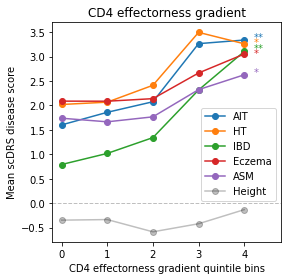

facs_cd8 ['UKB_460K.disease_AID_ALL', 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP', 'PASS_IBD_deLange2017', 'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 'UKB_460K.disease_ASTHMA_DIAGNOSED', 'UKB_460K.body_HEIGHTz'] (2196, 37)


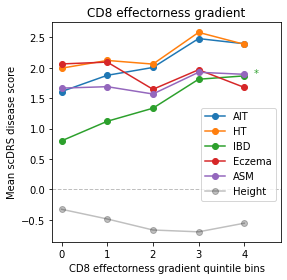

In [14]:
# Traits
score = 'tms_facs'
trait_list = ['UKB_460K.disease_AID_ALL',
              'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',
              'PASS_IBD_deLange2017',  
              'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 
              'UKB_460K.disease_ASTHMA_DIAGNOSED',
              'UKB_460K.body_HEIGHTz'
             ]

for cov_name in ['facs_cd4', 'facs_cd8']:
    df_plot = dic_cov[cov_name].copy()
    df_plot = df_plot.join(dic_score[score][['%s.norm_score'%x for x in trait_list]])
    df_plot['bin'] = pd.qcut(df_plot['effectorness'], q=5, labels=False)
    print(cov_name, trait_list, df_plot.shape)
    
    plt.figure(figsize=[4.1,4])
    i_color = 0
    y_text = 5
    for trait in trait_list:
        alpha_=0.25 if trait=='UKB_460K.body_HEIGHTz' else 1
        color_='k' if trait=='UKB_460K.body_HEIGHTz' else 'C%d'%i_color
        temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%trait: np.mean})
        plt.plot(temp_df.index, temp_df['%s.norm_score'%trait], 'o-', 
                 label=DF_TRAIT_INFO.loc[trait, 'Code'], color=color_, alpha=alpha_)
        if cov_name=='facs_cd4':
            y_text = min(y_text-0.1, temp_df['%s.norm_score'%trait][4])
        else:
            y_text = temp_df['%s.norm_score'%trait][4]
        plt.text(4.2, y_text, dic_stats['%s.reg_marginal'%cov_name].loc[trait,'P_STR.effectorness'], 
                 color=color_, alpha=alpha_)
        i_color+=1
    plt.axhline(y=0, ls="--", color="k", lw=1, alpha=0.25)
    plt.xlim([-0.2,4.8])
    plt.legend(loc='center right', bbox_to_anchor=[1,0.4])
    plt.xlabel('%s quintile bins'%dic_title[cov_name])
    plt.ylabel('Mean scDRS disease score')
    plt.title(dic_title[cov_name])
    plt.tight_layout()
#     plt.savefig(FIG_PATH+'/dpt_trait_corr.%s.svg'%cov_name)
    plt.show()
#     break